**Introduction:**

This notebook contains the implementation of L1 pruning technique of LeNet300-100 model on MNIST dataset

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision import datasets
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install pytorch_model_summary
from pytorch_model_summary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Check for Device Availability**

In [ ]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cpu


In [ ]:
# Set Hyperparameters
input_size = 784    # 28 x 28, flattened to be 1-D tensor
hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 32
learning_rate = 0.0012

**Download and Prepare Dataset**

In [ ]:
# Create train and test_data loaders
train_data = torchvision.datasets.MNIST("./",train=True,download=True ,transform=ToTensor())
train_data_loaded = torch.utils.data.DataLoader(train_data,
                                          batch_size=32,
                                          shuffle=True)

# Creating Data Loader object for creating the Test set by using the field train=False 
test_data = torchvision.datasets.MNIST("./",train=False,download=True,transform=ToTensor())
test_data_loaded = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

**Specify Model**

In [ ]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
        # Define layers-
        self.fc1 = nn.Linear(in_features = input_size, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.out = nn.Linear(in_features = 100, out_features = 10) 
    
    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [ ]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
        # Define layers-
        self.fc1 = nn.Linear(in_features = input_size, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.output = nn.Linear(in_features = 100, out_features = 10)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return self.output(out)
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [ ]:
model = LeNet300()
model.to(torch.device(device))

LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# Specify loss functions
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)
epochs = 20

In [ ]:
# Train model
for epoch in range(epochs):                        # iterate over number of epochs
    running_loss = 0.0
    for i,images in enumerate(train_data_loaded):  # iterate over the batches of training data
        batch_images,batch_labels = images
        batch_images = batch_images.to(device)     
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()  
        outputs = model(batch_images)              # computing forward pass 
        loss = criterion(outputs, batch_labels)    # Calculating loss
        loss.backward()                            # Calculating the gradients
        optimizer.step()
        running_loss += loss.item()

        if i % 200 == 199: 
          print(f'[{epoch + 1}, {i + 1:5d}] loss : {running_loss / 2000:.3f}')
          running_loss = 0.0

[1,   200] loss : 0.064
[1,   400] loss : 0.030
[1,   600] loss : 0.024
[1,   800] loss : 0.021
[1,  1000] loss : 0.015
[1,  1200] loss : 0.017
[1,  1400] loss : 0.014
[1,  1600] loss : 0.013
[1,  1800] loss : 0.013
[2,   200] loss : 0.009
[2,   400] loss : 0.008
[2,   600] loss : 0.010
[2,   800] loss : 0.010
[2,  1000] loss : 0.010
[2,  1200] loss : 0.009
[2,  1400] loss : 0.010
[2,  1600] loss : 0.008
[2,  1800] loss : 0.009
[3,   200] loss : 0.006
[3,   400] loss : 0.005
[3,   600] loss : 0.006
[3,   800] loss : 0.006
[3,  1000] loss : 0.007
[3,  1200] loss : 0.007
[3,  1400] loss : 0.006
[3,  1600] loss : 0.007
[3,  1800] loss : 0.006
[4,   200] loss : 0.003
[4,   400] loss : 0.004
[4,   600] loss : 0.005
[4,   800] loss : 0.004
[4,  1000] loss : 0.004
[4,  1200] loss : 0.005
[4,  1400] loss : 0.005
[4,  1600] loss : 0.005
[4,  1800] loss : 0.006
[5,   200] loss : 0.002
[5,   400] loss : 0.003
[5,   600] loss : 0.003
[5,   800] loss : 0.004
[5,  1000] loss : 0.004
[5,  1200] loss 

In [ ]:
# Train model
for epoch in range(epochs):                        # iterate over number of epochs
    running_loss = 0.0
    for index,(images, labels) in enumerate(train_data_loaded):  # iterate over the batches of training data
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if index % 200 == 199: 
          print(f'[{epoch + 1}, {index + 1:5d}] loss : {running_loss / 2000:.3f}')
          running_loss = 0.0

[1,   200] loss : 0.063
[1,   400] loss : 0.029
[1,   600] loss : 0.023
[1,   800] loss : 0.019
[1,  1000] loss : 0.019
[1,  1200] loss : 0.017
[1,  1400] loss : 0.016
[1,  1600] loss : 0.013
[1,  1800] loss : 0.013
[2,   200] loss : 0.011
[2,   400] loss : 0.010
[2,   600] loss : 0.009
[2,   800] loss : 0.010
[2,  1000] loss : 0.009
[2,  1200] loss : 0.009
[2,  1400] loss : 0.009
[2,  1600] loss : 0.009
[2,  1800] loss : 0.009
[3,   200] loss : 0.005
[3,   400] loss : 0.005
[3,   600] loss : 0.005
[3,   800] loss : 0.007
[3,  1000] loss : 0.005
[3,  1200] loss : 0.007
[3,  1400] loss : 0.007
[3,  1600] loss : 0.007
[3,  1800] loss : 0.007
[4,   200] loss : 0.004
[4,   400] loss : 0.004
[4,   600] loss : 0.004
[4,   800] loss : 0.004
[4,  1000] loss : 0.004
[4,  1200] loss : 0.005
[4,  1400] loss : 0.005
[4,  1600] loss : 0.005
[4,  1800] loss : 0.005
[5,   200] loss : 0.003
[5,   400] loss : 0.003
[5,   600] loss : 0.003
[5,   800] loss : 0.004
[5,  1000] loss : 0.004
[5,  1200] loss 

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "lenet300_mnist.pth")
print('Model saved successfully')

Model saved successfully


In [ ]:
for layer, param in model.named_parameters():
    print(f"layer.name: {layer} & param.shape = {param.shape}")

layer.name: fc1.weight & param.shape = torch.Size([300, 784])
layer.name: fc1.bias & param.shape = torch.Size([300])
layer.name: fc2.weight & param.shape = torch.Size([100, 300])
layer.name: fc2.bias & param.shape = torch.Size([100])
layer.name: out.weight & param.shape = torch.Size([10, 100])
layer.name: out.bias & param.shape = torch.Size([10])


In [ ]:
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import time

In [ ]:
# Pruning Function
def get_sparsity_accuracy(nmodel, test_data_loaded, device):
  """
  Calculating sum of all weights = 0 in the model.
  """
  global_sparsity = float(torch.sum(nmodel.fc1.weight == 0)) 
  global_sparsity += float(torch.sum(nmodel.fc2.weight == 0))

  """
  Calculate total number of weights in the model.
  """
  total_no_of_weights = float(nmodel.fc1.weight.nelement() + 
                              nmodel.fc2.weight.nelement())
  """
    Calculating Sparsity =  (sum of all weights equal to 0) / (total number of weights in the model)
  """

  percent_sparsity = 100.0 * (global_sparsity/total_no_of_weights)
  print("Global sparsity: {:.2f}%".format(percent_sparsity))

  """
    Calculating the Accuracy of the pruned model on the Test set
  """

  num_correct = 0
  time_ = 0

  for i,images in enumerate(test_data_loaded):
      batch_images,batch_labels = images                           # iterate over the batches of training data
      batch_images = batch_images.to(device)
      batch_labels = batch_labels.to(device)
      with torch.no_grad():
          start = time.time()
          outputs = nmodel(batch_images)                           # computing forward pass 
          end = time.time()
          num_correct += (batch_labels == outputs.max(dim=1)[1])   # Calculating total number of correct outputs 
          time_ += end - start
  accuracy = 100*num_correct.sum()/len(test_data_loaded.dataset)   # Accuracy = numbr of correct outputs / total test samples
  print("Accuracy: {:.2f}%".format(accuracy))
  return [percent_sparsity,round(float(accuracy),2),float(time_)/float(i)]

In [ ]:
# Iitializing list of k values
k_list = [val/100 for val in [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]]

1)  Perform Weight Pruning to prune away k% neurons/units for k in  [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

2)  Choose all layers other than the output layer and rank the weights using the absolute values
    by using the l1_unstructured function. 

3)  Calculate Sparsity in layers and the Accuracy of the Pruned model on the Test set.

In [ ]:
data = []
for k in k_list:
  nmodel = LeNet300()
  nmodel.load_state_dict(torch.load("lenet300_mnist.pth"))
  nmodel.to(device)

  nmodel.eval()
  
  for name, module in nmodel.named_modules():
    if name not in ["", 'out']:
      prune.l1_unstructured(module, name='weight', amount=k)
  data.append(get_sparsity_accuracy(nmodel,test_data_loaded,device))

Global sparsity: 0.00%
Accuracy: 97.91%
Global sparsity: 25.00%
Accuracy: 97.93%
Global sparsity: 50.00%
Accuracy: 97.90%
Global sparsity: 60.00%
Accuracy: 97.95%
Global sparsity: 70.00%
Accuracy: 97.40%
Global sparsity: 80.00%
Accuracy: 96.44%
Global sparsity: 90.00%
Accuracy: 81.25%
Global sparsity: 95.00%
Accuracy: 37.84%
Global sparsity: 97.00%
Accuracy: 14.83%
Global sparsity: 99.00%
Accuracy: 9.75%


In [ ]:
# Plot sparsity/accuracy table
import pandas as pd
df = pd.DataFrame(data,columns=['% Sparsity', '% Accuracy',"Execution Time"])
print(df) 

   % Sparsity  % Accuracy  Execution Time
0         0.0       97.91        0.001882
1        25.0       97.93        0.001822
2        50.0       97.90        0.001865
3        60.0       97.95        0.001850
4        70.0       97.40        0.001823
5        80.0       96.44        0.001870
6        90.0       81.25        0.001897
7        95.0       37.84        0.001853
8        97.0       14.83        0.001844
9        99.0        9.75        0.001898


In [ ]:
print(data)

[[0.0, 97.91, 0.001882081079964686], [25.0, 97.93, 0.0018220573964745107], [50.0, 97.9, 0.001864686156764175], [60.0, 97.95, 0.0018501113159487947], [70.0, 97.4, 0.0018232663472493489], [80.0, 96.44, 0.001869796502469766], [90.0, 81.25, 0.001897457874182499], [95.0, 37.84, 0.0018528206179840396], [97.0, 14.83, 0.0018440328463159427], [99.0, 9.75, 0.0018982453779740767]]


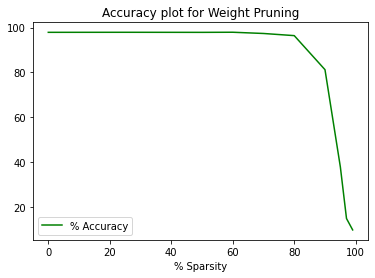

In [ ]:
# Plot accuracy plot for weight pruning
df.plot(kind='line', x = '% Sparsity', y='% Accuracy', color='green')
plt.title('Accuracy plot for Weight Pruning')
plt.show()

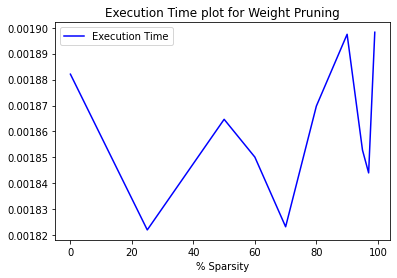

In [ ]:
df.plot(kind = 'line', x = '% Sparsity', y = "Execution Time", color = 'blue')
plt.title("Execution Time plot for Weight Pruning")
plt.show()

In [ ]:
torch.save(nmodel.state_dict(), "pruned_lenet300_mnist.pth")
print('Model saved successfully')

Model saved successfully


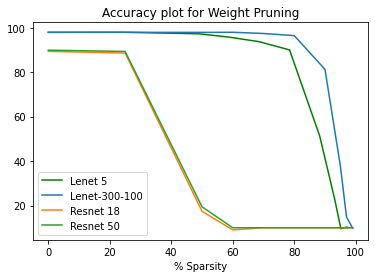

In [ ]:
lenet5_data = [[0.0, 97.94, 0.060360400363652394], [24.52591083955646, 97.96, 0.0007608635256988834], [49.049558723693146, 97.26, 0.0006649927659468217], [58.85947046843177, 95.76, 0.0006527997026539812], [68.66938221317041, 93.69, 0.0006432774091007734], [78.47929395790902, 90.0, 0.0006381068566832879], [88.28920570264765, 51.22, 0.0006473714655095881], [93.19303009730709, 22.62, 0.0006484359201758799], [95.1572754016746, 9.59, 0.0006653491896812362], [97.11699479520254, 10.28, 0.0006796085473262902]]
lenet5_df = pd.DataFrame(lenet5_data,columns=['% Sparsity', '% Accuracy',"Execution Time"])

lenet100_data = [[0.0, 97.91, 0.001882081079964686], [25.0, 97.93, 0.0018220573964745107], [50.0, 97.9, 0.001864686156764175], [60.0, 97.95, 0.0018501113159487947], [70.0, 97.4, 0.0018232663472493489], [80.0, 96.44, 0.001869796502469766], [90.0, 81.25, 0.001897457874182499], [95.0, 37.84, 0.0018528206179840396], [97.0, 14.83, 0.0018440328463159427], [99.0, 9.75, 0.0018982453779740767]]
lenet100_df = pd.DataFrame(lenet100_data,columns=['% Sparsity', '% Accuracy',"Execution Time"])

resnet18_data = [[0.0, 89.36, 0.004443052487495618], [25.0, 88.59, 0.0043421540504846815], [50.0, 17.39, 0.0043526184864533255], [60.0, 9.02, 0.004493277806502122], [70.0, 10.0, 0.004999043085636237], [80.0, 10.0, 0.004368517643366105], [90.0, 10.0, 0.006090054145226112], [95.0, 10.0, 0.00435026181049836], [97.0, 10.0, 0.004341325698754726], [99.0, 10.0, 0.004421176054538825]]
resnet18_df = pd.DataFrame(resnet18_data,columns=['% Sparsity', '% Accuracy',"Execution Time"])

resnet50_data = [[0.0, 89.9, 0.010758129449991079], [25.0, 89.31, 0.013541722908998147], [50.0, 19.42, 0.0105247573974805], [60.0, 10.0, 0.01057653090892694], [70.0, 10.0, 0.010656688457880264], [80.0, 10.0, 0.010625059788043682], [90.0, 10.0, 0.01126955869870308], [95.0, 10.0, 0.011066348124773074], [97.0, 10.0, 0.01054756610821455], [99.0, 10.0, 0.010651837556790084]]
resnet50_df = pd.DataFrame(resnet50_data,columns=['% Sparsity', '% Accuracy',"Execution Time"])

ax = lenet5_df.plot(kind='line', x = '% Sparsity', y='% Accuracy', color='green', label='Lenet 5')
lenet100_df.plot(x ='% Sparsity', y='% Accuracy', label='Lenet-300-100', ax=ax)
resnet18_df.plot(x ='% Sparsity', y='% Accuracy', label='Resnet 18', ax=ax)
resnet50_df.plot(x ='% Sparsity', y='% Accuracy', label='Resnet 50', ax=ax)

plt.title('Accuracy plot for Weight Pruning')
plt.show()